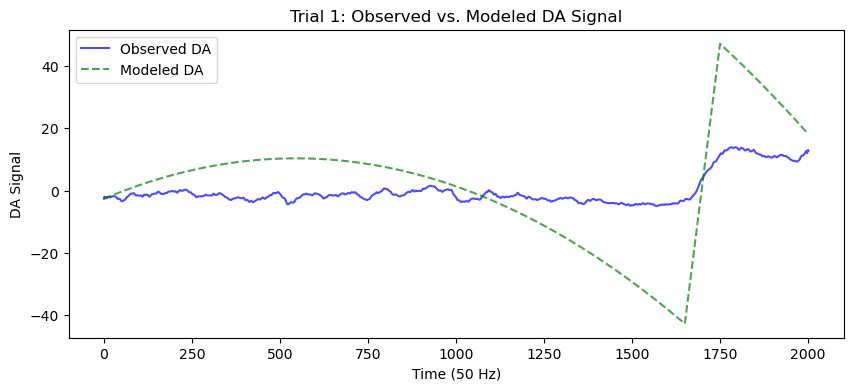

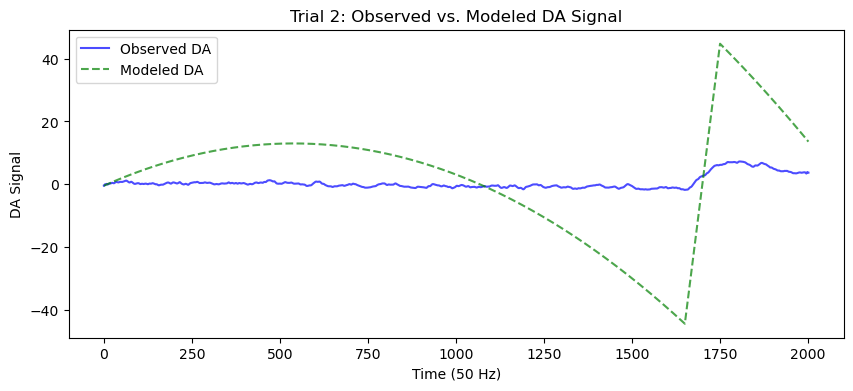

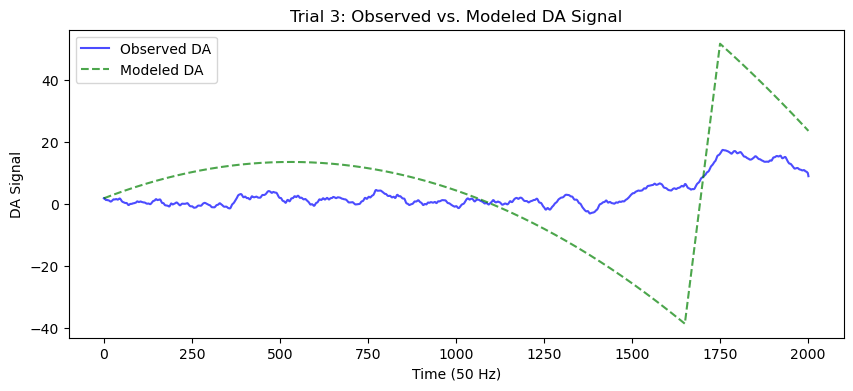

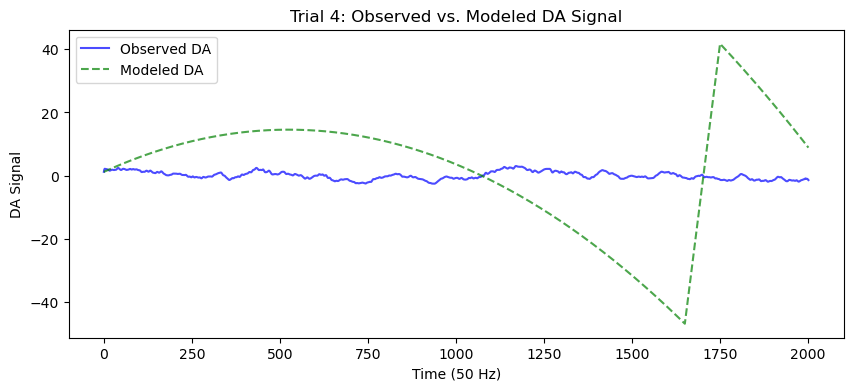

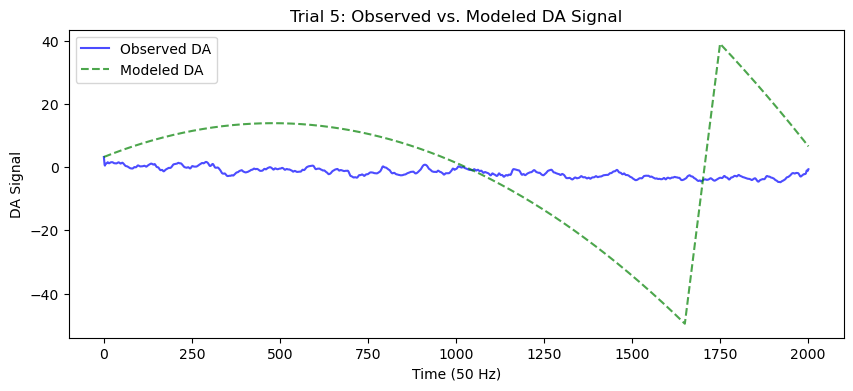

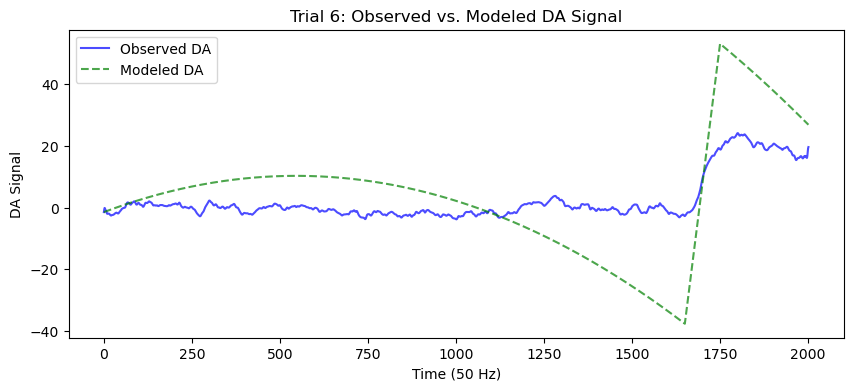

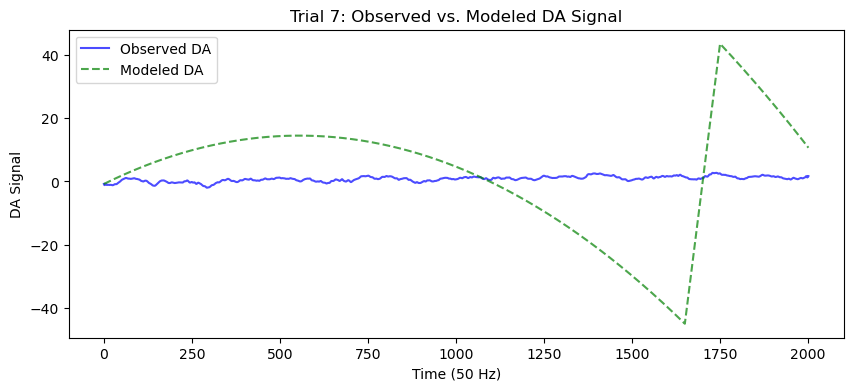

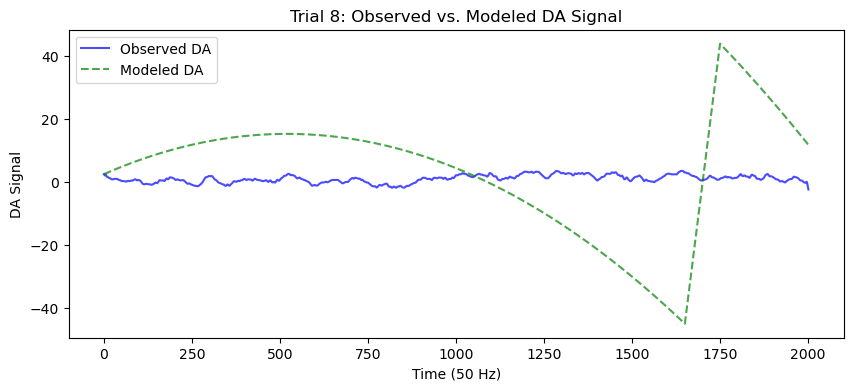

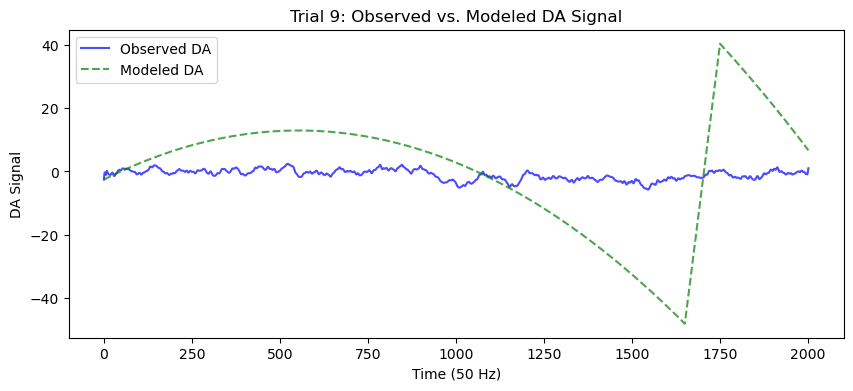

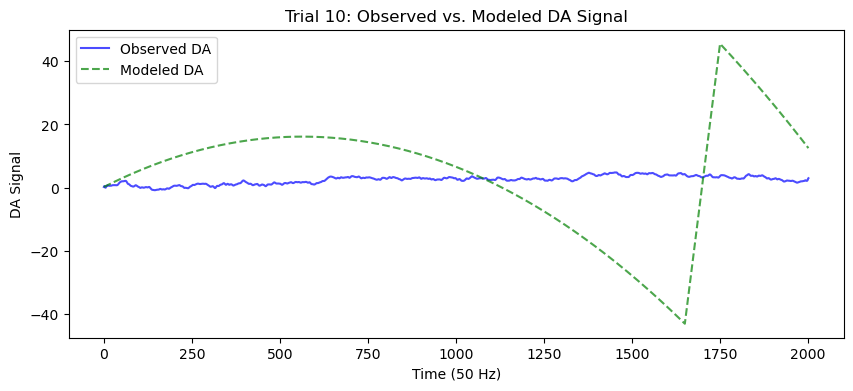

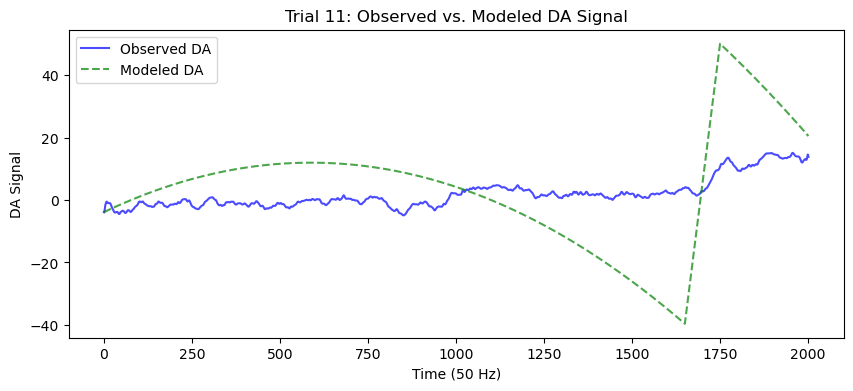

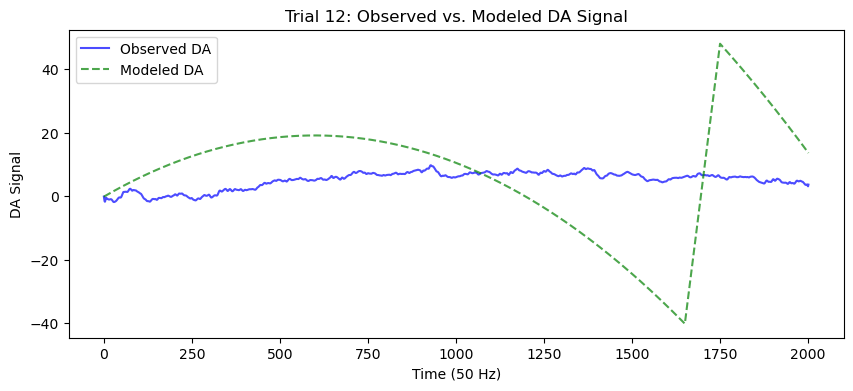

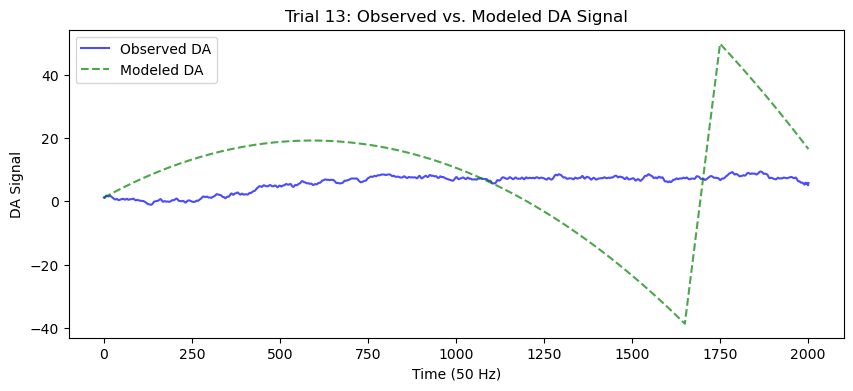

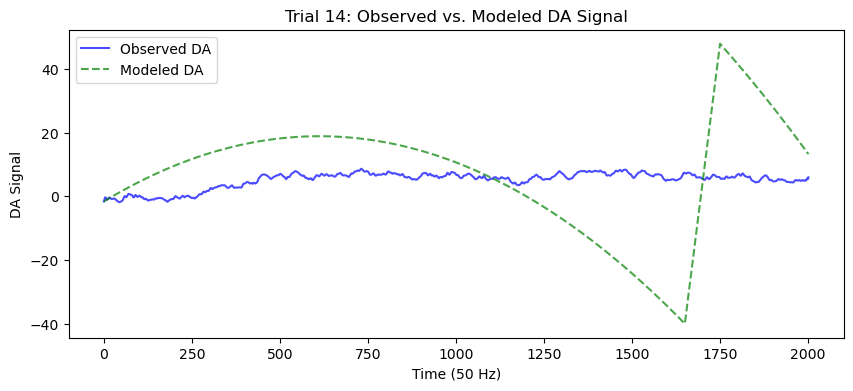

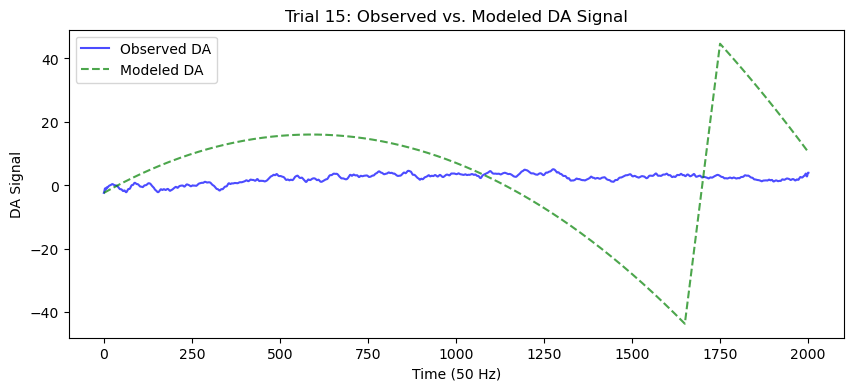

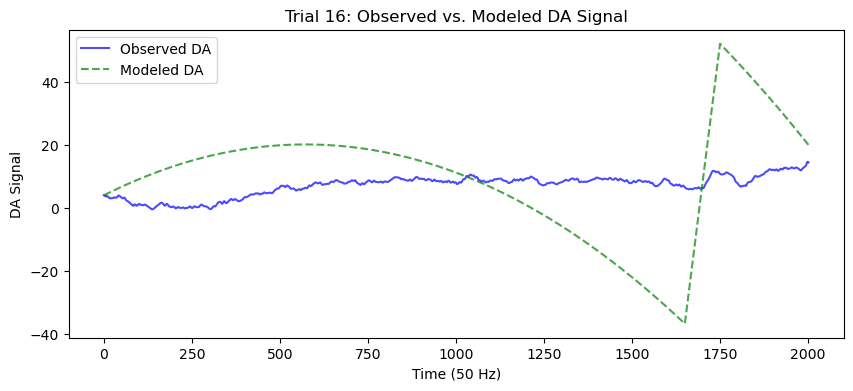

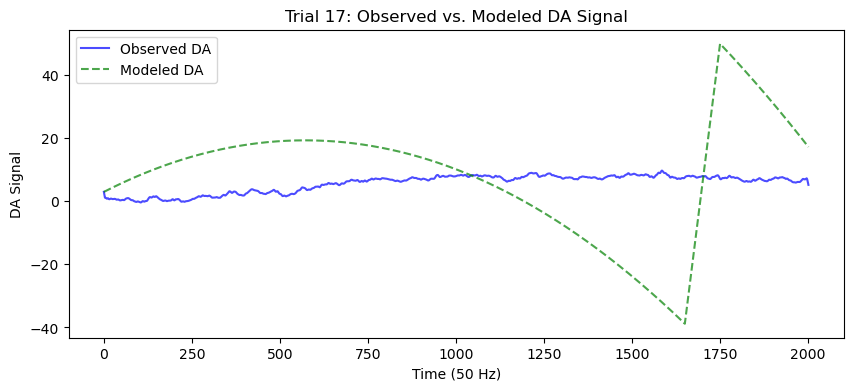

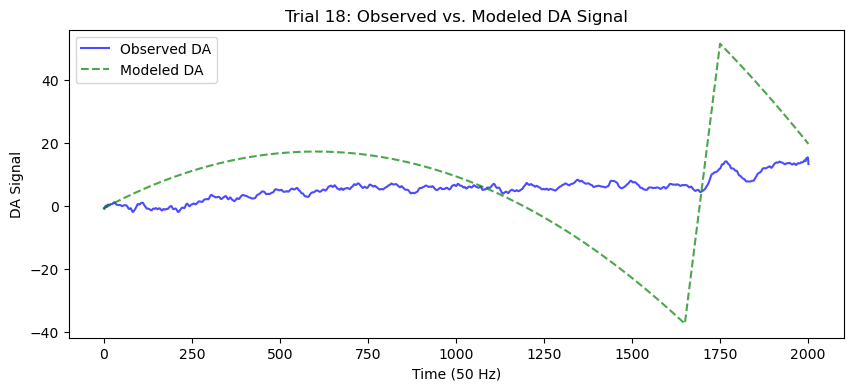

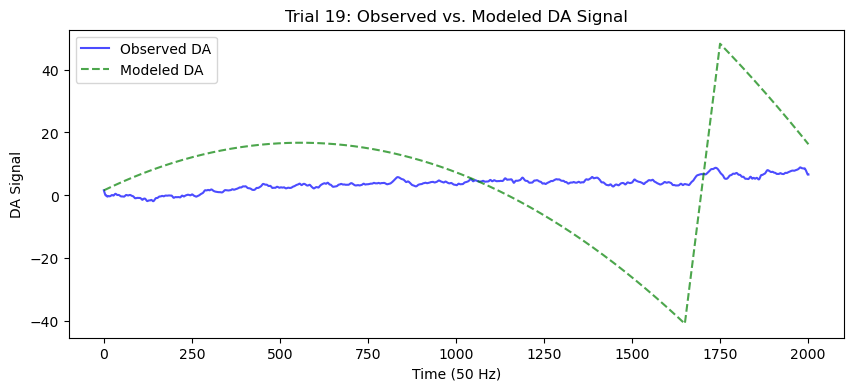

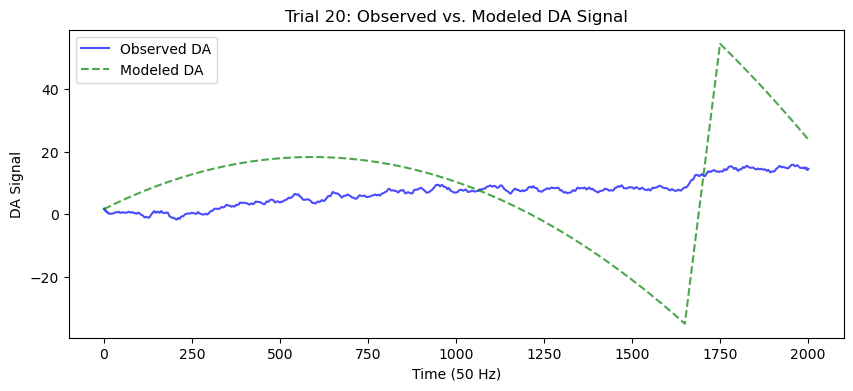

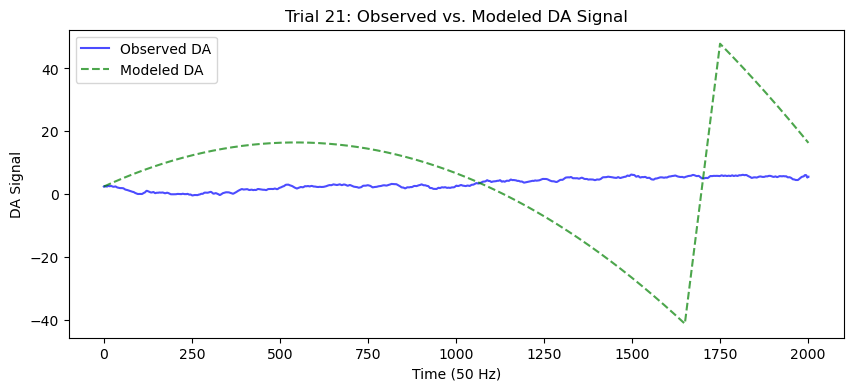

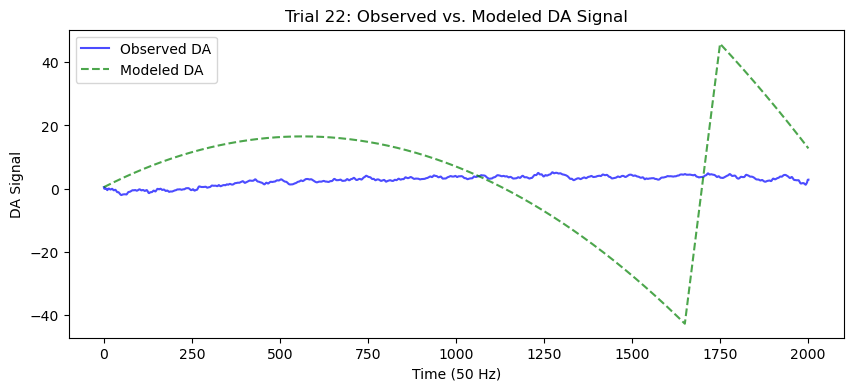

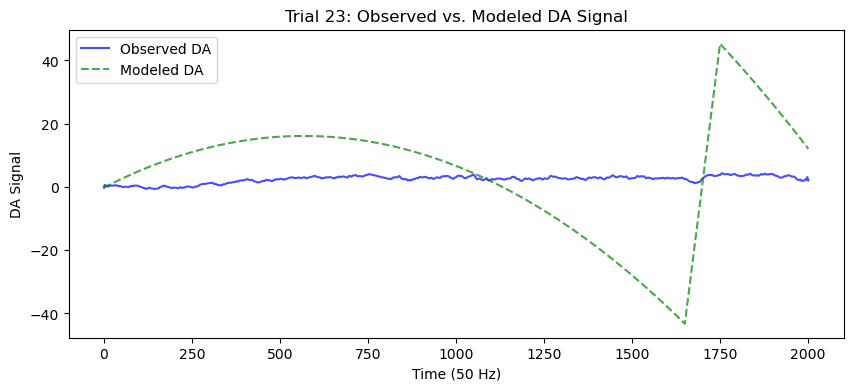

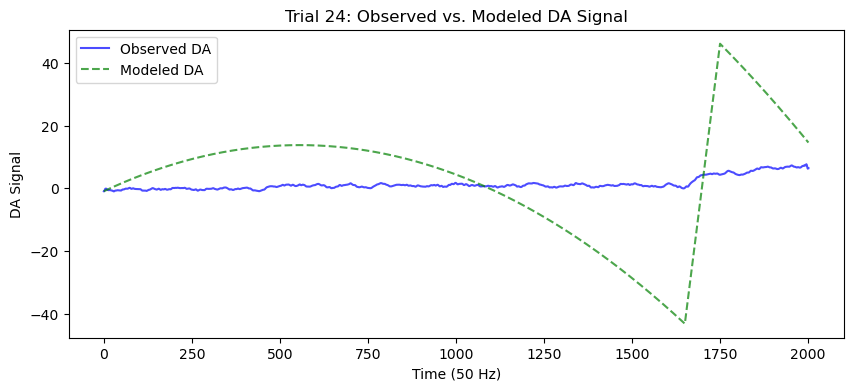

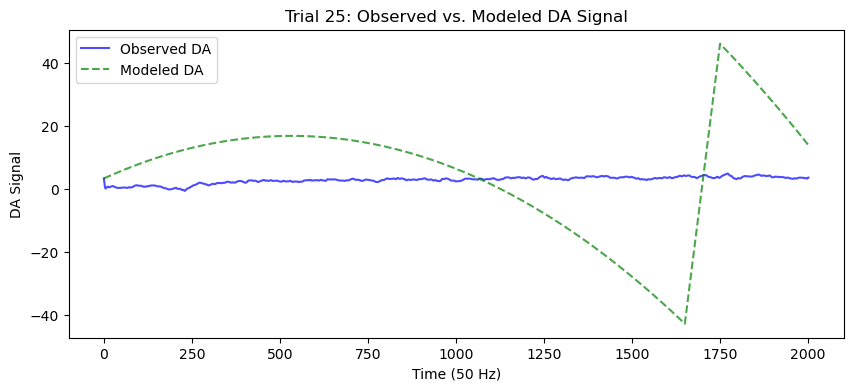

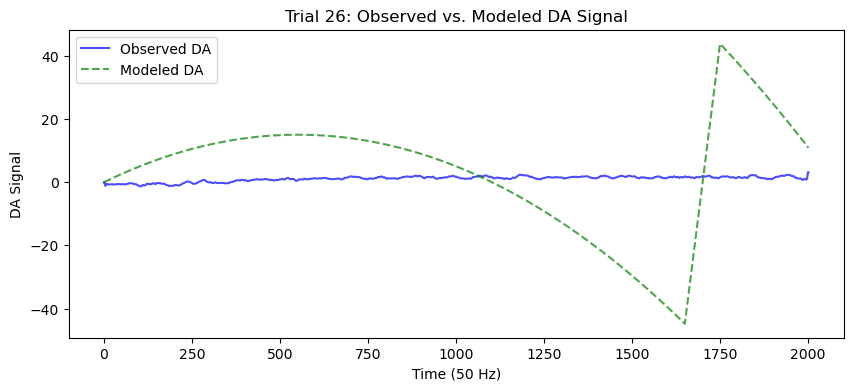

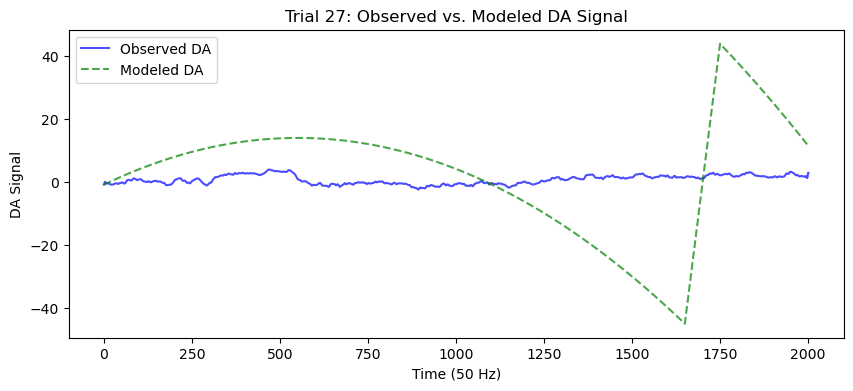

Overall MSE across all trials: 341.33045280858556
Optimized Parameters for Each Trial:
    Time Coeff  Baseline     Gamma  Alpha  Trial
0     0.000129 -0.070200  0.323861    0.5      1
1     0.000138 -0.073916  0.324263    0.5      2
2     0.000123 -0.065115  0.323039    0.5      3
3     0.000144 -0.075211  0.324598    0.5      4
4     0.000137 -0.065743  0.323310    0.5      5
5     0.000116 -0.063504  0.322681    0.5      6
6     0.000147 -0.081605  0.325374    0.5      7
7     0.000140 -0.072561  0.324113    0.5      8
8     0.000150 -0.082947  0.325675    0.5      9
9     0.000149 -0.083730  0.325755    0.5     10
10    0.000136 -0.079789  0.325193    0.5     11
11    0.000160 -0.095524  0.327561    0.5     12
12    0.000153 -0.090562  0.326630    0.5     13
13    0.000163 -0.099620  0.327919    0.5     14
14    0.000157 -0.092550  0.326871    0.5     15
15    0.000146 -0.083409  0.325649    0.5     16
16    0.000148 -0.084626  0.325903    0.5     17
17    0.000148 -0.088931  0.326

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load Data
fiber_data = pd.read_csv("./data/yoked/DP116_allTrial_signal.csv", header=None)
num_trials = fiber_data.shape[0]
num_time_steps = fiber_data.shape[1]
shock_start, shock_end = 1650, 1750

# Define the value function
def value_function(t, params):
    return params[0] * t + params[1]

# Define Tanya-like TD error calculation
def td_error(t, params, shocks, gamma, alpha):
    V_t = value_function(t, params)
    V_t1 = value_function(t + 1, params)
    return shocks[t] + gamma * V_t1 - V_t

# Define Tanya-like model
def tanya_model(trial_data, s_t_vector, params):
    params_without_gamma_alpha = params[:-2]
    gamma = params[-2]
    alpha = params[-1]
    num_time_steps = len(trial_data)

    # Initialize predicted signal array
    predicted_signal = np.zeros(num_time_steps)
    predicted_signal[0] = trial_data[0]  # Initialize with observed signal

    # Update predictions recursively
    for t in range(num_time_steps - 1):
        td = td_error(t, params_without_gamma_alpha, s_t_vector, gamma, alpha)
        predicted_signal[t + 1] = td + predicted_signal[t]

    return predicted_signal

# Define likelihood function
def likelihood(params, trial_data, s_t_vector):
    predicted_signal = tanya_model(trial_data, s_t_vector, params)
    residuals = trial_data[1:] - predicted_signal[1:]
    log_likelihood = -0.5 * np.sum(residuals ** 2)
    return -log_likelihood

# Optimization for each trial
def optimize_tanya_model(trial_index):
    # Extract observed signal for the trial
    trial_data = fiber_data.values[trial_index, :]

    # Create external stimulus vector (shock binary)
    s_t_vector = np.zeros(num_time_steps)
    s_t_vector[shock_start:shock_end] = 1  # Shock window

    # Initial guesses and bounds
    initial_params = [0.1, 0.1, 0.3, 0.5]  # [time_coeff, baseline, gamma, alpha]
    bounds = [(None, None), (None, None), (0, 1), (0, 1)]

    # Optimize parameters
    result = minimize(
        likelihood,
        initial_params,
        args=(trial_data, s_t_vector),
        method="L-BFGS-B",
        bounds=bounds
    )
    optimal_params = result.x
    modeled_signal = tanya_model(trial_data, s_t_vector, optimal_params)

    return trial_index, modeled_signal, optimal_params

# Sequential optimization and plotting
results = []
observed_signals = []
modeled_signals = []

for trial_index in range(num_trials):
    trial_result = optimize_tanya_model(trial_index)
    results.append(trial_result)
    observed_signal = fiber_data.values[trial_index, :]
    modeled_signal = trial_result[1]

    observed_signals.append(observed_signal)
    modeled_signals.append(modeled_signal)

    # Plot observed vs. modeled signal for the trial
    plt.figure(figsize=(10, 4))
    plt.plot(observed_signal, label="Observed DA", color="blue", alpha=0.7)
    plt.plot(modeled_signal, label="Modeled DA", color="green", linestyle="--", alpha=0.7)
    plt.title(f"Trial {trial_index + 1}: Observed vs. Modeled DA Signal")
    plt.xlabel("Time (50 Hz)")
    plt.ylabel("DA Signal")
    plt.legend()
    plt.show()

# Calculate overall MSE across all trials
def calculate_overall_mse(observed_signals, modeled_signals):
    total_mse = 0
    for obs, mod in zip(observed_signals, modeled_signals):
        total_mse += np.mean((obs - mod) ** 2)
    return total_mse / len(observed_signals)

overall_mse = calculate_overall_mse(observed_signals, modeled_signals)
print(f"Overall MSE across all trials: {overall_mse}")

# Save results as a DataFrame
optimized_params = [res[2] for res in results]
optimized_params_df = pd.DataFrame(
    optimized_params,
    columns=["Time Coeff", "Baseline", "Gamma", "Alpha"]
)
optimized_params_df["Trial"] = np.arange(1, num_trials + 1)

print("Optimized Parameters for Each Trial:")
print(optimized_params_df)

# Optional: Save results to CSV
do_save = False
if do_save:
    optimized_params_df.to_csv("optimized_parameters_tanya.csv", index=False)
